# TREPAN algorithm

## Introduction
The TREPAN algorithm was introduced in the 1995 paper, "Extracting Tree-Structured Representations of Trained Networks" by M. Craven and colleagues. This innovative algorithm was designed with the purpose of enabling analysis of decision-making processes in neural networks or other trained models, and then presenting those findings in a manner that's easily understandable by humans.

One such human-friendly mode of presenting complex information is through Decision Trees, which offer a graphical and intuitive way of representing intricate processes. The appeal of decision trees lies in their logical structure that simplifies the interpretation of multifaceted domains.

The TREPAN algorithm seeks to leverage this intuitive simplicity; given a trained network and the dataset it was trained on, the goal of TREPAN is to create a concept description that is not only easily comprehensible but also classifies instances in a manner consistent with the network. In essence, TREPAN transforms the complex inner workings of a trained model into a transparent, accessible, and human-readable format.

In [1]:
import os
import torch
import math
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy
from itertools import combinations

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
from graphviz import Digraph

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import confusion_matrix, accuracy_score

## Our trained model we want to analyze
We want to train a ANN model using the Iris Dataset for our exploration of the TREPAN algorithm

## Our Dataset - The Iris Dataset


![Iris Flowers](./iris-dataset.png)

The **Iris dataset**, also referred to as Fisher's Iris dataset, is a multivariate dataset introduced by the British statistician, eugenicist, and biologist Ronald Fisher in his 1936 paper "The use of multiple measurements in taxonomic problems". It is arguably one of the most famous datasets in the field of Machine Learning, often used for testing out classification algorithms.

## Dataset Overview

The dataset contains **150 observations** of iris flowers from three different species - *Setosa*, *Versicolour*, and *Virginica*. Each observation includes **four features** representing the physical dimensions (in cm) of the flower:

1. Sepal Length
2. Sepal Width
3. Petal Length
4. Petal Width

The objective when using this dataset is typically to build a model that can predict the species of the flower based on these four features.

## Data Source

The Iris dataset is publicly available and is included in the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/iris).

## Our implementation

In our implementation, we will use the Iris Dataset. We will create a vanilla feed forward neural network with two fully connected layers (nn.Linear) together with a ReLU activation function. 


In [2]:
class IrisNN(nn.Module):
    """
    A neural network model for the Iris dataset classification task.

    This class extends the PyTorch `nn.Module` and implements a simple feedforward neural network
    with a single hidden layer for the Iris dataset classification. It includes methods for training,
    fitting, and predicting using the neural network.

    Attributes:
        fc1 (nn.Linear): First fully connected layer, mapping input features to hidden dimensions.
        relu (nn.ReLU): Rectified Linear Unit activation function.
        fc2 (nn.Linear): Second fully connected layer, mapping hidden dimensions to output dimensions.
        softmax (nn.Softmax): Softmax activation function for converting logits to probabilities.

    Example:
        iris_nn = IrisNN(input_dim=4, hidden_dim=10, output_dim=3)
        iris_nn.fit(X, y, epochs=100, batch_size=16, lr=0.01)
        y_pred = iris_nn.predict(X)
    """
    def __init__(self, input_dim, output_dim):
        super(IrisNN, self).__init__()
        self.fc1 = nn.Linear(in_features=input_dim, out_features=16)
        self.fc2 = nn.Linear(in_features=16, out_features=12)
        self.relu = nn.ReLU()
        self.output = nn.Linear(in_features=12, out_features=output_dim)
 
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.output(x)
        return x

    def fit(self, X, y, epochs=10, batch_size=20, lr=0.01): 
        # Convert to PyTorch tensors
        X_train = torch.tensor(X, dtype=torch.float32)
        y_train = torch.tensor(y, dtype=torch.long)

        # Create data loaders
        train_data = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

        # Define the loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=lr)

        # Training loop
        for epoch in range(epochs):
            for data, labels in train_loader:
                optimizer.zero_grad()
                outputs = self.forward(data)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            # Print loss every 10 epochs
            if epoch % 10 == 0:
                print(f"Epoch: {epoch}, Loss: {loss.item()}")

    def predict(self, X):
        # Convert input to PyTorch tensor
        X = torch.tensor(X, dtype=torch.float32)

        # Get model predictions
        with torch.no_grad():
            output = self.forward(X)
            _, predicted_labels = torch.max(output, 1)

        return predicted_labels.numpy()

Epoch: 0, Loss: 1.0877560377120972
Epoch: 10, Loss: 0.22161638736724854
Epoch: 20, Loss: 0.09254917502403259
Epoch: 30, Loss: 0.04215478152036667
Accuracy: 1.00


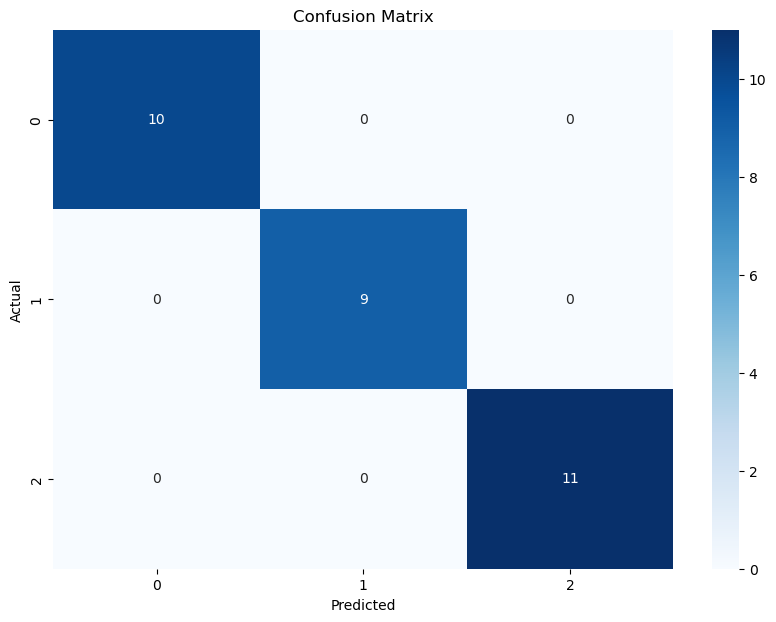

In [3]:
#Train ANN to represent with TREPAN
iris = load_iris()
X = iris.data
y = iris.target

model_path = "iris_model.pkl"
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check if the model already exists
if os.path.exists(model_path):
    # Load the existing model
    model = torch.load(model_path)
else:
    # Train a new model
    model = IrisNN(4, 3)
    model.fit(X_train, y_train, epochs=40)

    # Save the trained model
    # torch.save(model, model_path)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## The algorithm

![](./trepan.png)

### The Oracle
In TREPAN, we define the term **oracle**. The Oracle is the agent between our TREPAN building process and the trained model we want to analyze. We can **query** the oracle to achieve more training data, as well as predicting the labels on the data.

The oracle is used for three different purposes: 
* to determine the class labels for the network's training examples; 
* to select splits for each of the tree's internal nodes; and
* and to determine if a node covers instances of only one class. These aspects of the algorithm are discussed in more detail below. 

#### Instance generation
For continuous data, we use the Kernel Density Function to map the training data distribution. We use this model thereafter to generate more instances.

For discrete data, we use a simple frequency count, and use these counts as weights for generation.

Instance generation is a non-deterministic manner, and is the reason we obtain different models each time.


In [4]:
# Define the Oracle class
class Oracle:
    """
    This is the oracle class used to bind the tree expansion and neural network together. We use this to generate more instances of values, model feature distribution and to keep track of the neural network.
    """
    def __init__(self, model, X, y):
        self.model = model
        self.X = X
        self.y = y
        self.discrete_features, self.continuous_features = self._separate_features_by_type(self.X)
        self.discrete_distributions = self._model_discrete_features()
        self.continuous_kdes = self._model_continuous_features()

    def _separate_features_by_type(self, X, discrete_threshold=0.1):
        discrete_features = []
        continuous_features = []

        if isinstance(X, pd.DataFrame):
            X = X.values
        elif not isinstance(X, np.ndarray):
            raise ValueError("X should be either a pandas DataFrame or a numpy array.")
            
        num_instances, num_features = X.shape

        for col in range(num_features):
            unique_values = np.unique(X[:, col])
            num_unique_values = len(unique_values)
            
            if (np.issubdtype(X[:, col].dtype, np.number) and num_unique_values / num_instances <= discrete_threshold) or not np.issubdtype(X[:, col].dtype, np.number):
                discrete_features.append(X[:, col])
            else:
                continuous_features.append(X[:, col])

        if len(discrete_features) > 0:
            discrete_features = np.column_stack(discrete_features)
        else:
            discrete_features = np.empty((num_instances, 0))

        if len(continuous_features) > 0:
            continuous_features = np.column_stack(continuous_features)
        else:
            continuous_features = np.empty((num_instances, 0))

        return discrete_features, continuous_features

    def _model_discrete_features(self):
        distributions = []
        for col in range(self.discrete_features.shape[1]):
            counts = np.bincount(self.discrete_features[:, col].astype(int))
            distributions.append(counts / counts.sum())
        return distributions

    def _model_continuous_features(self):
        kdes = []
        for col in range(self.continuous_features.shape[1]):
            kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(self.continuous_features[:, col].reshape(-1, 1))
            kdes.append(kde)
        return kdes

    def generate_instances(self, hard_constraints, current_split, num_instances):
        new_instances = []
        instances_created = 0

        while instances_created < num_instances:
            new_instance = []

            # Generate discrete features. Note: Non-deterministic
            for col, distribution in enumerate(self.discrete_distributions):
                value = np.random.choice(len(distribution), p=distribution)
                new_instance.append(value)

            # Generate continuous features. Note: Non-deterministic
            for col, kde in enumerate(self.continuous_kdes):
                value = round(kde.sample()[0][0], 1)
                new_instance.append(value)

            # Check if the generated instance satisfies all the constraints
            satisfies_constraints = True

            if hard_constraints:
                for constraint in hard_constraints:
                    m = constraint.m
                    conditions = constraint.conditions
                    satisfied_conditions_count = 0

                    for feature_idx, threshold, direction in conditions:
                        if direction == "<=" and new_instance[feature_idx] <= threshold:
                            satisfied_conditions_count += 1
                        if direction == ">" and new_instance[feature_idx] > threshold:
                            satisfied_conditions_count += 1

                    if constraint.satisfied and satisfied_conditions_count < m:
                        satisfies_constraints = False
                        break
                    elif not constraint.satisfied and satisfied_conditions_count >= m:
                        satisfies_constraints = False
                        break

            if satisfies_constraints and current_split:
                # Check if the generated instance satisfies the current split
                m = current_split.m
                conditions = current_split.conditions
                satisfied_conditions_count = 0

                for feature_idx, threshold, direction in conditions:
                    if direction == "<=" and new_instance[feature_idx] <= threshold:
                        satisfied_conditions_count += 1
                    if direction == ">" and new_instance[feature_idx] > threshold:
                        satisfied_conditions_count += 1

                if current_split.satisfied and satisfied_conditions_count >= m:
                    new_instances.append(new_instance)
                    instances_created += 1
                elif not current_split.satisfied and satisfied_conditions_count < m:
                    new_instances.append(new_instance)
                    instances_created += 1
            elif satisfies_constraints and not current_split:
                new_instances.append(new_instance)
                instances_created += 1

        return np.array(new_instances)

## Explaination

![](./trepan.png)

### Initialization
1. We define an empty queue.
2. We predict all the labels for the data in X.
3. We initialize the root node in the tree as a leaf node.
4. We put a tuple (Node, training_examples, constraionts) into queue.

### While-loop
It runs as long as 
1. We still have less nodes than the tree_size_limit; or
2. The queue is not empty

While this is True:
1. We pop a tuple from the queue, in a best first manner.
Best-first expansion is different from traditional depth first expansion. In this case, if there are several nodes in the queue, it selects the one that yields the highest score from
f(n) = reach(n) * (1 - fidelity(n)), where n is the node we evaluate, reach(n) is the fraction of original training examples that reach this node, and fidelity(n) is the estimated fidelity of the tree to the network for those instances.

2. After we have identified the best tuple in the queue, we pop it, and name it N.
We define the set of instances to N for examples_N, and the constraints at this point for constraints_N.

3. Next, we identify all the possible splits in the dataset. For continuous data, we order the data, and set the split point in between two adjacent values in the dataset. This set is then shrinked by applying the constraints, so we remove illegal splits. In first iteration there are no constraints.

4. We use the **oracle** to generate more instances that follows the constraints, and we label them.

5. Next, we calculate the best initial binary split. That is, we use the set F_N and calculate which one has the best gain ratio.

Gain Ratio is a modification of the Information Gain concept in decision tree algorithms, and it is used for handling the bias issue towards attributes with a large number of outcomes.

Information Gain, a fundamental concept in decision tree algorithms, measures the reduction in entropy (uncertainty or impurity) achieved because of the split on a particular attribute. However, Information Gain has a bias towards attributes with many outcomes. That is, it tends to favor attributes that have a large number of distinct values over those with fewer distinct values. 

To overcome this bias, the Gain Ratio concept was introduced. The Gain Ratio is calculated by dividing the Information Gain by the so-called "Intrinsic Value" of a split. 

The Intrinsic Value measures the amount of information required to classify an instance given the split, without considering the class labels. It is calculated similarly to entropy but uses the proportions of the instances falling into each split subset instead of class proportions. 

By normalizing the Information Gain using the Intrinsic Value, Gain Ratio essentially penalizes attributes with many outcomes and reduces their bias. 

In conclusion, Gain Ratio is used to choose the attribute that gives the highest normalized reduction in entropy and is particularly useful for handling multi-valued attributes in decision tree algorithms.

6. We now have the best split from the candidate set and its respective gain ratio score.

7. Now, we use this as a the seed in a M-of-N split search. Here, N is the splitting criterias, while M is the number of those that need to be satisfied in order for the split to return true. A binary split is by definition a 1-of-1 split. The search expands by two operators:
* m-of-(n+1) - we introduce a new splitting criteria without changing the threshold
* (m+1)-of-(n+1) - we increase both the threshold and the splitting criterias.

The search end when the number of N is equal to the number of features in the dataset.

8. If the M-of-N search yields a better gain ratio than the binary split, we select that split criteria instead.

9. We define our current node as a internal node instead of a leaf node.

For [True, False] of our splitting critera:

10. We define C, a child node of N, and define it as leaf node.

11. We add the split as constraint for C

12. We generate more instances that follows the constraints, and predict them.

13. If we can say with some confidence that the majority of the labels are of one class, it we do not add it to the queue, and we designate the majority class label as the label on that leaf node.

14. If there is no clear class majority, it creates a new tuple (C, examples_C, constraints_c) and adds it to queue.



In [5]:
# Define the Node class
class Node:
    def __init__(self, training_examples, training_predictions, constraints, leaf, parent=None):
        self.leaf = leaf
        self.training_examples = training_examples
        self.training_predictions = training_predictions
        self.hard_constraints = constraints
        self.split = None
        self.children = []
        self.parent = parent
        self.label = None
        self.score = 0

    def _is_leaf(self):
        return len(self.children) == 0

# Define the MofN class
class MofN:
    def __init__(self, m, conditions, gain_ratio = 0):
        self.m = m
        self.conditions = conditions
        self.gain_ratio = gain_ratio
        self.satisfied = True

# Define the TREPAN class
class TREPAN:
    def __init__(self, oracle, X, y, max_tree_size, max_conditions, max_children, cutoff, num_of_instances):
        self.oracle = oracle
        self.root = None
        self.features = X
        self.X_true = X
        self.y_true = y
        self.y_predicted = self.oracle.model.predict(self.X_true) 
        self.max_tree_size = max_tree_size
        self.max_conditions = max_conditions
        self.max_children = max_children
        self.current_amount_of_nodes = 0
        self.cutoff = cutoff
        self.S_min = len(self.X_true) // 10
        self.number_of_instances_for_generation = num_of_instances
    
    def predict(self, X):
        """
        Predict the class labels for the given instances using the TREPAN decision tree.

        Args:
            X (numpy.ndarray): An array of instances for which class labels need to be predicted.

        Returns:
            numpy.ndarray: An array of predicted class labels for the input instances.
        """

        def traverse_tree(node, instance):
            """
            Traverse the tree recursively to find the leaf node corresponding to the given instance.

            Args:
                node (Node): The current node being traversed.
                instance (numpy.ndarray): A single instance for which a leaf node needs to be found.

            Returns:
                Node: The leaf node corresponding to the given instance.
            """

            # If the current node is a leaf, return the node
            if node.leaf:
                return node

            # If the current node is an internal node, traverse its children based on the m-of-n conditions
            else:
                for child in node.children:
                    if self._satisfies_m_of_n_conditions(child.hard_constraints, instance):
                        return traverse_tree(child, instance)


        # Initialize an array to store predicted class labels
        predictions = np.empty(X.shape[0], dtype=int)

        # Iterate through the instances and predict class labels
        for idx, instance in enumerate(X):
            leaf_node = traverse_tree(self.root, instance)
            predictions[idx] = leaf_node.label

        return predictions

    def fit(self):

        # Define an empty queue
        queue = []

        # Use the oracle to predict y_predicted
        # This happens in the init process of TREPAN

        # Initialize root node as leaf
        self.root = Node(self.X_true, self.y_predicted, [], True)

        # Identify all possible candidate splits
        F = self._identify_candidate_splits(self.features)

        #Push node to queue
        queue.append(self.root)

        # Initialize best first expansion
        self._best_first_tree_expansion(queue, F)

    def _best_first_tree_expansion(self, queue, F):
        """
        Expands the decision tree by selecting the best node and its corresponding split.
        This function iteratively evaluates nodes in the queue, computes their gain ratio, and
        generates child nodes until the maximum tree size is reached or the queue is empty.

        Args:
            queue (list): List of nodes to be evaluated and expanded.
            F (list): List of candidate splits to be considered for each node.
        """

        # 0. Run as long as there are still nodes in the queue and we havent reached limit
        while queue and self.current_amount_of_nodes < self.max_tree_size:
            
            # 1. Evaluate which node in the queue has the highest score, and we pop this one
            # The formula we use is f(n) = reach(n) * (1 - fidelity(n))
            # Todo: Fix fidelity to compare towards tree.
            N = self._get_best_scoring_node_in_queue(queue)
            queue.remove(N)

            # 2. Define F_N, which is the subset of all candidate splits which satisfies the current constraints
            F_N = self._extract_subset_of_candidate_splits(F, N.hard_constraints)

            # 3. Query the oracle to get more instances
            X_from_oracle = self.oracle.generate_instances(N.hard_constraints, None, num_instances = self.number_of_instances_for_generation - (len(N.training_examples)))
            y_from_oracle = self.oracle.model.predict(X_from_oracle)

            # 4. Calculate gain ratio on all splits in F_N using gain ratio criterion
            # Let best_initial_split be the top scoring candidate split in F_N using N.training_examples and X_from_oracle
            best_initial_split, best_initial_gain_ratio = self._get_best_binary_split(F_N, N, X_from_oracle, y_from_oracle)

            # 5. Convert it a m-of-n format, that is a 1-of-{best_initial_split}
            best_binary_split = MofN(1, best_initial_split, best_initial_gain_ratio)

            # 6. If the gain ratio = 1, then we already have a splitting condition which cannot be improved
            # by a m-of-n search. Therefore, we only start the m-of-n search if we do not have a gain_ratio of 1.
            if not best_binary_split.gain_ratio == 1:
                
                best_split = self._calculate_best_m_of_n_split(best_binary_split, F_N, N, X_from_oracle, y_from_oracle)
                
            # If there is a max gain initial split
            else:
                best_split = best_binary_split

            # 8. Set current node as an internal node
            N.leaf = False
            N.split = best_split


            # For every logical outcome of the m-of-n, we create a child node
            #for new_constraints_c in best_split.outcomes:
            for split_satisfied in [True, False]:
                
                # 11. Append constraints from parent node N
                best_split.satisfied = split_satisfied
                constraints_c = deepcopy(N.hard_constraints) + deepcopy([best_split])

                # 12. Update original training data using the new constraints
                child_mask = self._apply_m_of_n_constraints(constraints_c, N.training_examples)

                # if there indeed is a split, and not one side is empty
                if not (True in child_mask and False in child_mask):
                    N.leaf = True
                    break    

                if split_satisfied:
                    training_examples_c = deepcopy(N.training_examples[child_mask])
                    training_predictions_c = deepcopy(N.training_predictions[child_mask])
                else:
                    training_examples_c = deepcopy(N.training_examples[~child_mask])
                    training_predictions_c = deepcopy(N.training_predictions[~child_mask])

                
                # 13. Generate new set of instances for evaluation. The number is the defined number in init for evaluation minus the number from training examples.
                if len(training_examples_c) < self.S_min:
                    instances_for_evaluation = self.oracle.generate_instances(N.hard_constraints, best_split, self.S_min - (len(training_examples_c)))
                else:
                    instances_for_evaluation = np.array([])

                # 14. Create a new child node as leaf node, define it as child of N, and add to node count (for stopping criteria).
                if training_examples_c.size != 0:
                    C = Node(training_examples_c, training_predictions_c, constraints_c, True, parent=N)
    
                    N.children.append(C)
                    self.current_amount_of_nodes += 1

                    # 15. Get the most common class prediction using the oracle
                    most_common_class, p_c = self._most_common_class_proportion(instances_for_evaluation, training_examples_c, training_predictions_c)
                    
                    # 16. If proportion is larger than some cut-off value, let it be a leaf and assign target class
                    if p_c >= self.cutoff:
                        C.label = most_common_class
                    
                    # Otherwise, append child node to the queue.
                    else:
                        C.label = most_common_class
                        queue.append(C)

        if queue:
            for node in queue:
                most_common_class, p_c = self._most_common_class_proportion(np.array([]), node.training_examples, node.training_predictions)
                node.label = most_common_class

    def _identify_candidate_splits(self, X):
        """
        Identify all possible candidate splits for all features in the input feature matrix X.

        Parameters
        ----------
        X : numpy.ndarray
            The input feature matrix.

        Returns
        -------
        candidate_splits : list of tuples
            A list of candidate splits, where each split is represented as a tuple (feature_index, threshold).
        """
        # Get the number of instances and features
        num_instances, num_features = X.shape
        
        # Initialize an empty list to store candidate splits
        candidate_splits = []

        # Iterate over each feature column in the input matrix X
        for col in range(num_features):
            # Find the unique values for the current feature
            unique_values = np.unique(X[:, col])
            
            # If there's only one unique value, continue to the next feature
            if len(unique_values) == 1:
                continue

            # If there are more than two unique values, calculate thresholds as the midpoint between adjacent unique values
            if len(unique_values) > 2:
                thresholds = (unique_values[:-1] + unique_values[1:]) / 2.0
            else:
                thresholds = unique_values

            # Append the feature index and candidate split threshold to the list of candidate splits
            for threshold in thresholds:
                candidate_splits.append((col, round(threshold, 2), '<='))
                candidate_splits.append((col, round(threshold, 2), '>'))

        return candidate_splits

    def _get_best_binary_split(self, F_N, node, X_from_oracle, y_from_oracle):
        best_gain_ratio = -1
        best_candidate_split = None
        X = np.vstack((node.training_examples, X_from_oracle))
        y = np.concatenate((node.training_predictions, y_from_oracle))

        for candidate in F_N:
            gain_ratio = self._calculate_gain_ratio(X, y, [candidate])

            if gain_ratio > best_gain_ratio:
                best_gain_ratio = gain_ratio
                best_candidate_split = [candidate]

        return best_candidate_split, best_gain_ratio
                
    def _calculate_best_m_of_n_split(self, best_binary_split, F_N, node, X_from_oracle, y_from_oracle):
        X = np.vstack((node.training_examples, X_from_oracle))
        y = np.concatenate((node.training_predictions, y_from_oracle))

        best_m_of_n_split = best_binary_split
        current_conditions = list(best_binary_split.conditions)

        def condition_exists(conditions, condition):
            for cond in conditions:
                if cond[0] == condition[0] and cond[2] == condition[2]:
                    return True
            return False
    
        while len(current_conditions) < self.max_conditions:
            # Find the best condition to add from F_N
            best_new_condition = None
            best_gain_ratio = 0
            best_m = deepcopy(best_m_of_n_split.m)

            for candidate in F_N:
                if candidate not in current_conditions and not condition_exists(current_conditions, candidate):
                    # Try adding the candidate to the conditions
                    extended_conditions = current_conditions + [candidate]

                    # Calculate gain ratio for m-of-n+1
                    gain_ratio_m_of_n_plus_1 = self._calculate_gain_ratio_m_of_n(X, y, extended_conditions, best_m)
                    # Calculate gain ratio for m+1-of-n+1
                    gain_ratio_m_plus_1_of_n_plus_1 = self._calculate_gain_ratio_m_of_n(X, y, extended_conditions, best_m + 1)

                    if gain_ratio_m_plus_1_of_n_plus_1 > gain_ratio_m_of_n_plus_1:
                        candidate_gain_ratio = gain_ratio_m_plus_1_of_n_plus_1
                        candidate_m = best_m + 1
                    else:
                        candidate_gain_ratio = gain_ratio_m_of_n_plus_1
                        candidate_m = best_m

                    #decimal error fix. COuld be 1.00000002 for instance.
                    if candidate_gain_ratio > 1:
                        candidate_gain_ratio = 1

                    # To make sure that the added complexity added by increasing the search has some substantial increase in gain, we add a minimum increase of 0.01.
                    if (candidate_gain_ratio - 0.01) > best_gain_ratio:
                        best_new_condition = candidate
                        best_gain_ratio = candidate_gain_ratio
                        best_m = candidate_m

            # Add the best new condition to the current conditions
            if best_new_condition is not None:
                current_conditions.append(best_new_condition)

                # Update the best_m_of_n_split with the new conditions and gain ratio
                if best_gain_ratio > best_m_of_n_split.gain_ratio:
                    best_m_of_n_split = MofN(best_m, current_conditions, best_gain_ratio)

            # Break the loop if the gain ratio is 1.0 or if the number of children exceeds the maximum allowed
            if best_gain_ratio == 1.0 or self._get_child_count_for_MofN_structure(best_m, len(current_conditions)) >= self.max_children:
                break

        return best_m_of_n_split

    def _apply_constraints(self, constraints, X):
        # Create a boolean mask with the same length as the number of instances in X, initialized with True values
        mask = np.ones(len(X), dtype=bool)

        # Iterate over each constraint in the list of constraints
        for col, threshold, direction in constraints:
            if direction == '<=':
                # Create a boolean mask for instances where the feature value at column 'col' is less than or equal to the threshold
                current_mask = X[:, col] <= threshold
            
            elif direction == '>':
                current_mask = X[:, col] > threshold
            
            else:
                raise SyntaxError("Wrong syntax for direction in tuple. Should be '<=' or '>'.")
            
            # Apply the current mask to the main mask using the AND operation
            mask = mask & current_mask

        # Return the mask
        return mask
    
    def _apply_m_of_n_constraints(self, mofn_split_list, X):
        overall_mask = np.ones(len(X), dtype=bool)

        # Iterate over each MofN split object in the list
        for mofn_split in mofn_split_list:
            m = mofn_split.m
            conditions = mofn_split.conditions

            # Initialize an array to count the number of satisfied conditions for each instance
            satisfied_conditions_count = np.zeros(len(X), dtype=int)

            for feature_idx, threshold_value, less_than_or_greater in conditions:
                if less_than_or_greater == '<=':
                    satisfied_conditions_count += (X[:, feature_idx] <= threshold_value)
                else:
                    satisfied_conditions_count += (X[:, feature_idx] > threshold_value)

            # Get the mask for instances satisfying the m-of-n split
            m_of_n_mask = satisfied_conditions_count >= m
            overall_mask &= m_of_n_mask

        return overall_mask


    def _get_child_count_for_MofN_structure(self, m, n):
        # From statistics, we are familiar with nCr, which is how many combinations of n items where r is selected, 
        # when order does not matter and repetitions are not allowed. We can use this here to calculate how 
        # many children a certain m-of-n structure will produce. Note that now, n is a number and not a condition for this calculation.
        # In our case, it will be nCm. For instance a 2-of-{A, B, C} will be a 2-of-3 structure with outcomes {A, B}, {A, C} and {B, C}
        # The number of children can be calculated: nCm = (n!) / ((n-m)! * m!)
        return ((math.factorial(n)) / (math.factorial(n-m) * math.factorial(m)))
    
    def _get_best_scoring_node_in_queue(self, queue):
        best_score = float('-inf')
        best_node = None

        for node in queue:
            score = self._calculate_node_score(node)
            node.score = score

            if score > best_score:
                best_score = score
                best_node = node
        
        return best_node

    def _calculate_node_score(self, node):
        """
        Calculate the score for a given node.
        
        !! This doesnt work yet !!

        Parameters
        ----------
        node : TrepanNode
            The node for which to calculate the score.
        X_true : numpy.ndarray
            The input feature matrix.
        y_true : numpy.ndarray
            The true labels.

        Returns
        -------
        score : float
            The node score.
        """
        # Apply the constraints of the node
        mask = self._apply_m_of_n_constraints(node.hard_constraints, node.training_examples)

        # Apply mask
        X_filtered = node.training_examples[mask]
        y_filtered = node.training_predictions[mask]

        # Calculate the fidelity
        y_pred = self.oracle.model.predict(X_filtered)
        fidelity = self._calculate_fidelity(y_filtered, y_pred)

        # Calculate the reach
        reach = self._calculate_reach(node.hard_constraints)

        # Calculate the node score
        score = reach * fidelity

        if math.isnan(score):
            return 0
        
        return score

    def _calculate_fidelity(self, y_true, y_pred):
        """
        Calculate the fidelity of the predicted values compared to the true values.

        Parameters
        ----------
        y_true : numpy.ndarray
            The true labels.
        y_pred : numpy.ndarray
            The predicted labels.

        Returns
        -------
        fidelity : float
            The fidelity score.
        """
        assert y_true.shape == y_pred.shape, "y_true and y_pred should have the same shape."
        return np.mean(y_true == y_pred)

    def _calculate_reach(self, constraints):
        """
        Calculate the reach of a given set of instances given a set of constraints.

        Parameters
        ----------
        X_true : numpy.ndarray
            The input feature matrix.
        constraints : list of tuples
            The constraints to apply.

        Returns
        -------
        reach : float
            The reach score.
        """
        num_instances, _ = self.X_true.shape
        num_instances_satisfying_constraints = 0

        if not constraints:
            return 1

        for instance in self.X_true:
            satisfies_constraints = True
            for constraint in constraints:
                    m = constraint.m
                    conditions = constraint.conditions
                    satisfied_conditions_count = 0

                    for feature_idx, threshold, direction in conditions:
                        if direction == "<=" and instance[feature_idx] <= threshold:
                            satisfied_conditions_count += 1
                            #satisfies_constraints = False
                            #break
                        if direction == ">" and instance[feature_idx] > threshold:
                            satisfied_conditions_count += 1
                            #satisfies_constraints = False
                            #break
                    
                    if satisfied_conditions_count < m:
                        satisfies_constraints = False
                        break

            if satisfies_constraints:
                    num_instances_satisfying_constraints += 1

        reach = num_instances_satisfying_constraints / num_instances
        return reach
    
    def _most_common_class_proportion(self, X_from_oracle, training_examples_c, training_predictions_c):
        # Predict the targets on the instances
        if X_from_oracle.size > 0:
            y_pred = self.oracle.model.predict(X_from_oracle)
            y = np.concatenate((training_predictions_c, y_pred))
        else:
            y = training_predictions_c    
                #y = training_predictions_c
        #while len(y) < self.S_min:

        if y.size == 0:
            return None
        
        # Count the occurrences of each class
        unique_classes, counts = np.unique(y, return_counts=True)

        # Find the index of the most common class
        most_common_class_idx = np.argmax(counts)

        # Calculate the proportion of the most common class
        most_common_class = unique_classes[most_common_class_idx]
        proportion = counts[most_common_class_idx] / y.size

        return most_common_class, proportion

    def _extract_subset_of_candidate_splits(self, F, constraints):
        """
        Extracts the subset of candidate splits that satisfy the list of constraints.

        :param F: list of candidate splits (tuples of structure (feature_idx, threshold))
        :param constraints: list of MofN constraints
        :return: list of candidate splits that satisfy the constraints
        """

        if not constraints:
            return F

        def satisfies_constraints(candidate_split):
            feature_idx, threshold, direction = candidate_split

            for constraint in constraints:
                constraint_conditions = constraint.conditions

                for constraint_feature_idx, constraint_threshold, constraint_direction in constraint_conditions:
                    if feature_idx == constraint_feature_idx:
                        if constraint_direction == "<=" and threshold > constraint_threshold:
                            return False
                        elif constraint_direction == ">" and threshold <= constraint_threshold:
                            return False

            return True

        result = [candidate_split for candidate_split in F if satisfies_constraints(candidate_split)]
        return result

    def _satisfies_m_of_n_conditions(self, mofn_constraints, instance):
        """
        Check if a given instance satisfies the m-of-n conditions of a specific node.

        Args:
        mofn_constraints (list of MofN objects): List of MofN constraints.
        instance (numpy array): The instance we want to check against the constraints.

        Returns:
        bool: True if the instance satisfies the m-of-n conditions, False otherwise.
        """

        all_constraints_satisfied = True

        for mofn_constraint in mofn_constraints:
            m = mofn_constraint.m
            conditions = mofn_constraint.conditions
            satisfied_conditions_count = 0

            for feature_idx, threshold, direction in conditions:
                if direction == "<=":
                    if instance[feature_idx] <= threshold:
                        satisfied_conditions_count += 1
                elif direction == ">":
                    if instance[feature_idx] > threshold:
                        satisfied_conditions_count += 1

            if satisfied_conditions_count >= m:
                constraint_satisfied = mofn_constraint.satisfied
            else:
                constraint_satisfied = not mofn_constraint.satisfied

            all_constraints_satisfied = all_constraints_satisfied and constraint_satisfied

        return all_constraints_satisfied

    def _calculate_gain_ratio(self, X, y, constraints):
        
        if not constraints:
            mask = np.ones(len(X), dtype=bool)
        else: 
            mask = self._apply_constraints(constraints, X)
        
        y_entropy = self._calculate_entropy(y)

        y_left = y[mask]
        y_right = y[~mask]

        # Calculate the entropy for both splits
        left_entropy = self._calculate_entropy(y_left)
        right_entropy = self._calculate_entropy(y_right)

        # Calculate the weighted average of the entropies
        left_weight = len(y_left) / len(y)
        right_weight = len(y_right) / len(y)
        avg_entropy = left_weight * left_entropy + right_weight * right_entropy

        # Calculate information gain
        info_gain = y_entropy - avg_entropy

        # Calculate intrinsic value
        intrinsic_value = -left_weight * np.log2(left_weight) - right_weight * np.log2(right_weight) if left_weight > 0 and right_weight > 0 else 0

        # Calculate gain ratio
        gain_ratio = info_gain / intrinsic_value if intrinsic_value != 0 else 0

        return gain_ratio

    def _calculate_gain_ratio_m_of_n(self, X, y, new_proposed_conditions, m):
        # Calculate the entropy of the parent node before splitting
        parent_entropy = self._calculate_entropy(y)

        gain_ratios = []

        # Iterate over each logical outcome of the m-of-n split using itertools.combinations
        for outcome in combinations(new_proposed_conditions, m):
            new_constraints = list(outcome)
            weighted_entropy = 0
            intrinsic_value = 0

            # Apply the constraints to the dataset
            child_mask = self._apply_constraints(new_constraints, X)
            child_examples = X[child_mask]
            child_predictions = y[child_mask]
            not_applicable = X[~child_mask]
            not_applicable_predictions = y[~child_mask]

            # Calculate the entropy of the resulting child node
            child_entropy = self._calculate_entropy(child_predictions)
            not_child_entropy = self._calculate_entropy(not_applicable_predictions)

            # Calculate the proportion of instances that fall into the child node
            child_proportion = len(child_examples) / len(X)

            # Update the weighted child entropy sum and intrinsic value sum
            weighted_entropy += ((child_proportion * child_entropy) + ((1 - child_proportion) * not_child_entropy))
            intrinsic_value -= ((child_proportion * np.log2(child_proportion)) + ((1 - child_proportion) * np.log2(1 - child_proportion)))
        
            # Calculate the information gain and gain ratio
            information_gain = parent_entropy - weighted_entropy
            gain_ratio = information_gain / intrinsic_value
        
            gain_ratios.append(gain_ratio)

        return np.mean(gain_ratios)

    def _calculate_intrinsic_value(self, y):
        num_instances = len(y)
        unique_labels, label_counts = np.unique(y, return_counts=True)
        proportions = label_counts / num_instances
        
        # Calculate the intrinsic value (split information)
        intrinsic_value = -np.sum(proportions * np.log2(proportions))
        
        return intrinsic_value

    def _calculate_entropy(self, y):
            num_instances = len(y)
            unique_labels, label_counts = np.unique(y, return_counts=True)
            probabilities = label_counts / num_instances
            entropy = -np.sum(probabilities * np.log2(probabilities))
            return entropy
    
    def print_tree(self, node=None, level=0):
        if node is None:
            node = self.root

        # Print the current node
        if node.leaf:
            print("  " * level + f"Leaf (Class: {node.label}, Constraints: ", end="")
            for mofn in node.hard_constraints:
                satisfaction = "Satisfied" if mofn.satisfied else "Not Satisfied"
                print(f"{satisfaction} {mofn.m}-of-{[condition for condition in mofn.conditions]}", end=", ")
            print(")")

        else:
            print("  " * level + f"Node (Split: {node.split.m}-of-{[condition for condition in node.split.conditions]}, Gain Ratio: {node.split.gain_ratio:.2f})")

        # Recursively print the children
        for child in node.children:
            self.print_tree(child, level + 1)


    def to_graphviz(self, node=None, graph=None, parent=None):
        if node is None:
            node = self.root

        if graph is None:
            graph = Digraph("TREPAN_Tree", format="png")
            graph.attr(rankdir="TB")

        node_id = f"{id(node)}"
        if node.leaf:
            constraints_str = ',\n'.join([f"{('Satisfied' if mofn.satisfied else 'Not Satisfied')} {mofn.m}-of-\n{[condition for condition in mofn.conditions]}" for mofn in node.hard_constraints])
            label = f"Leaf\n(Class: {node.label},\nConstraints:\n{constraints_str})"
        else:
            label = f"Node\n(Split: {node.split.m}-of-\n{[condition for condition in node.split.conditions]},\nGain Ratio: {node.split.gain_ratio:.2f})"

        graph.node(node_id, label=label)

        if parent is not None:
            graph.edge(f"{id(parent)}", node_id)

        for child in node.children:
            self.to_graphviz(child, graph, node)

        return graph


In [6]:
# TREPAN
oracle = Oracle(model, X_train, y_train)

#Parameters
max_number_of_nodes = 15
number_of_instances, max_conditions = X.shape
S_min = number_of_instances // 10
max_children_per_node = 5
proportion_to_determine_class_in_leaf_node = 0.70

trepan = TREPAN(oracle=oracle, X=X_train, y=y_train, max_tree_size=max_number_of_nodes, max_conditions=max_conditions, max_children=max_children_per_node, cutoff=proportion_to_determine_class_in_leaf_node, num_of_instances=number_of_instances)
trepan.fit()
trepan.print_tree()
graph = trepan.to_graphviz()
graph.render("trepan_tree", cleanup=True)
print("Image successfully generated")

# Predictions
y_test_pred = trepan.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_test_pred)
print("Accuracy Score:", accuracy)

# Confusion matrix
confusion_mat_2 = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(confusion_mat_2)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_mat_2, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#Fidelity
accuracy = accuracy_score(y_pred, y_test_pred)
print("Fidelity Score:", accuracy)

/home/anders/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/anders/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1025554/1695751300.py:655: RuntimeWarning: divide by zero encountered in log2
  intrinsic_value -= ((child_proportion * np.log2(child_proportion)) + ((1 - child_proportion) * np.log2(1 - child_proportion)))
/tmp/ipykernel_1025554/1695751300.py:655: RuntimeWarning: invalid value encountered in double_scalars
  intrinsic_value -= ((child_proportion * np.log2(child_proportion)) + ((1 - child_proportion) * np.log2(1 - child_proportion)))


Leaf (Class: None, Constraints: )
Image successfully generated


TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'

In [ ]:
graph